# The Peter Lynch Approach

**UI Suggestions:**
- Build a UI that includes three key components (1) a chat-bot responds to user's questions with Peter Lynch investment insights (2) a dashboard to display the key financial ratios of all selected stocks, see DataFrame fin_data_df. (3) print the stock long-short receommendation list made by the K-Mean Cluster.
- Set the Dow Jones stock portfolio to be the default selection, then allow users to add their own the stocks or remove some stocks from the default list. 
- Use my k-mean clustering algorithm below as the starting point, display the value-quality clustering figure and report the list of stocks to be long and the list of stocks to be short. 
- Ideally, you could include some high-level introduction and interpretation of the financial ratios reported in DataFrame fin_data_df into the question-answer pairs for your Chat-Bot. 

## reference: 
- https://home.csulb.edu/~pammerma/fin382/screener/lynch.htm

In [2]:
!pip install yahooquery

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for yahooquery from https://files.pythonhosted.org/packages/ab/98/bd176685b2175fa7a5283e2fc73a9a7338715015849c904cca6eb69b5082/yahooquery-2.4.1-py3-none-any.whl.metadata
  Obtaining dependency information for curl-cffi>=0.10.0 from https://files.pythonhosted.org/packages/6d/e4/15a253f9b4bf8d008c31e176c162d2704a7e0c5e24d35942f759df107b68/curl_cffi-0.13.0-cp39-abi3-win_amd64.whl.metadata
  Obtaining dependency information for pandas>=2.2.0 from https://files.pythonhosted.org/packages/c8/7b/bdcb1ed8fccb63d04bdb7635161d0ec26596d92c9d7a6cce964e7876b6c1/pandas-2.3.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for requests-futures>=1.0.1 from https://files.pythonhosted.org/packages/91/23/7c1096731c15c83826cb0dd42078b561a838aed44c36f370aeb815168106/requests_futures-1.0.2-py2.py3-none-any.whl.metadata
   ---------------------------------------- 0.0/50.7 kB ?

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bokeh 3.2.1 requires pillow>=7.1.0, which is not installed.
datashader 0.15.2 requires pillow, which is not installed.


In [4]:
!pip install yahoo_fin

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for yahoo_fin from https://files.pythonhosted.org/packages/c1/73/b8d385bbc01bacb66f589a36f6c108e0e847d1f982755bfcc7391735d560/yahoo_fin-0.8.9.1-py3-none-any.whl.metadata
  Obtaining dependency information for requests-html from https://files.pythonhosted.org/packages/24/bc/a4380f09bab3a776182578ce6b2771e57259d0d4dbce178205779abdc347/requests_html-0.10.0-py3-none-any.whl.metadata
  Obtaining dependency information for feedparser from https://files.pythonhosted.org/packages/7c/d4/8c31aad9cc18f451c49f7f9cfb5799dadffc88177f7917bc90a66459b1d7/feedparser-6.0.11-py3-none-any.whl.metadata
  Using cached feedparser-6.0.11-py3-none-any.whl.metadata (2.4 kB)
  Using cached sgmllib3k-1.0.0-py3-none-any.whl
  Obtaining dependency information for pyquery from https://files.pythonhosted.org/packages/76/f5/5067b48012967ea166b9bd0a015b69e0560e4c6e7c06f28d9bab8f9dd10b/pyquery-2.0.1-py3-none-a

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [5]:
import pandas as pd
from yahooquery import Ticker

from numpy import where
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_classification
from matplotlib import pyplot
from numpy import unique
from sklearn.cluster import KMeans

import yahoo_fin.stock_info as si
import warnings
warnings.filterwarnings("ignore", category=Warning)

import random
random.seed(42)  # Set seed

In [6]:
# 1. list all stocks enlisted in Dow Jone Index
stock_symbol_list = si.tickers_dow()
print(f"All {len(stock_symbol_list)} Stocks in Dow Jones: {stock_symbol_list}.")

All 30 Stocks in Dow Jones: ['AAPL', 'AMGN', 'AMZN', 'AXP', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX', 'DIS', 'GS', 'HD', 'HON', 'IBM', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'NVDA', 'PG', 'SHW', 'TRV', 'UNH', 'V', 'VZ', 'WMT'].


In [7]:
# 2. list important financial ratios for all stocks in the list
ticker = Ticker(stock_symbol_list) 
fin_data_dict = ticker.financial_data
fin_data_df = pd.DataFrame.from_dict(fin_data_dict, orient='index').T
print(fin_data_df)

# preprocess debt-to-equity ratio to equity-to-debt ratio
fin_data_df.loc['debtToEquity'] = 1 / fin_data_df.loc['debtToEquity']

                                   AAPL           AMGN            AMZN  \
maxAge                            86400          86400           86400   
currentPrice                     213.25         284.67          222.31   
targetHighPrice                   300.0          405.0           306.0   
targetLowPrice                    175.0          185.0           209.0   
targetMeanPrice               233.02553      314.33334        260.7143   
targetMedianPrice                 238.0          320.0           260.0   
recommendationMean              1.93333        2.34375         1.34286   
recommendationKey                   buy            buy      strong_buy   
numberOfAnalystOpinions              38             27              63   
totalCash                   55372001280     8028000256     93180002304   
totalCashPerShare                 3.731         14.922           8.737   
ebitda                   141696008192.0  15848999936.0  133831999488.0   
totalDebt                  10169800294

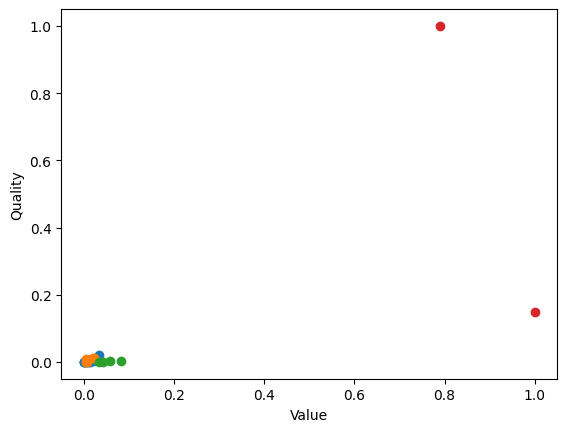

Long Stocks: 
 Index(['GS', 'JPM'], dtype='object')
Short Stocks: 
 Index(['AAPL', 'AMZN', 'MSFT', 'NVDA'], dtype='object')


In [4]:
# Transposing the DataFrame
data_full = fin_data_df.T 
# Replacing NaN values with 0
data = data_full.fillna(0)

# prepare raw data for clustering
X = data.drop(['maxAge','currentPrice','targetHighPrice', 'targetLowPrice', 
               'targetMeanPrice', 'targetMedianPrice', 'recommendationMean', 
               'recommendationKey', 'numberOfAnalystOpinions','financialCurrency'], axis=1).to_numpy()

# Initializing MinMaxScaler
scaler = MinMaxScaler()
# Applying Min-Max Scaling
X = scaler.fit_transform(X)

# k-means clustering
# define the model
# Set random seed for reproducibility
model = KMeans(n_clusters=4, random_state=100)
# fit the model
model.fit(X)
# assign a cluster to each example
yhat = model.predict(X)
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
 # get row indexes for samples with this cluster
 row_ix = where(yhat == cluster)
 # create scatter of these samples
 pyplot.scatter(X[row_ix, 0], X[row_ix, 1])

# show the plot
pyplot.xlabel('Value')
pyplot.ylabel('Quality')
pyplot.show()

# print alerted entities
print('Long Stocks: \n', data.index[yhat == 3])
print('Short Stocks: \n', data.index[yhat == 2])

In [7]:
data.head()

,maxAge,currentPrice,targetHighPrice,targetLowPrice,targetMeanPrice,targetMedianPrice,recommendationMean,recommendationKey,numberOfAnalystOpinions,totalCash,...,grossProfits,freeCashflow,operatingCashflow,earningsGrowth,revenueGrowth,grossMargins,ebitdaMargins,operatingMargins,profitMargins,financialCurrency
AAPL,86400,214.10,325.0,197.00,252.59052,255.0,2.02222,buy,39,53774999552,...,184102993920,9.383387e+10,108293996544,0.101,0.040,0.46519,0.34706,0.34459,0.24295,USD
AMGN,86400,315.04,389.0,185.00,315.94885,324.0,2.41935,buy,26,11973000192,...,22965999616,1.372588e+10,11489999872,-0.187,0.109,0.68711,0.45348,0.51805,0.12237,USD
AMZN,86400,194.95,306.0,203.00,264.92398,270.0,1.35821,strong_buy,63,101202001920,...,311670996992,4.463587e+10,115877003264,0.846,0.105,0.48854,0.18883,0.11291,0.09287,USD
AXP,86400,270.83,371.0,231.57,315.54040,322.5,2.57143,hold,24,41109999616,...,39382999040,0.000000e+00,14049999872,0.157,0.106,0.64813,0.00000,0.17832,0.16669,USD
BA,86400,172.83,250.0,113.00,196.20880,200.0,2.03571,buy,25,26261000192,...,-1735000064,-9.693000e+09,-12080000000,0.000,-0.308,-0.02608,-0.12302,-0.23947,-0.17765,USD
